<a href="https://colab.research.google.com/github/K-bNd/dnn-courses/blob/main/Autograd_Deepcourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Automatic Differentiation with Autograd</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

In this notebook, we will see that we don't need to define the gradients of all our fancy operations. Pytorch's autograd can automatically find the gradients for us.

After a few exercice on this, we will recode our MLP from [last course](https://deepcourse-epita.netlify.app/notebooks/Backpropagation_Deepcourse.ipynb) with the backward pass implemented with autograd.

Finally, we will discover `torch.nn`, the package containing pre-implemented deep learning layers and how we can code a MLP using it.

In the next code block, we are loading the data that will be useful later on.

Min and max value: 0.0, 1.0
Flatenned images shape: torch.Size([1797, 64])


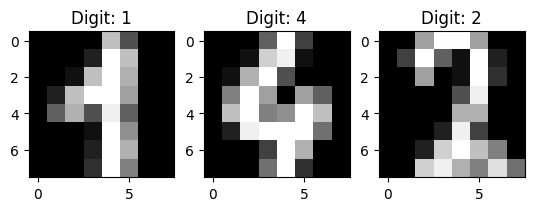

In [ ]:
%matplotlib inline

import torch
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
X = torch.tensor(digits["images"]).float()
Y = torch.tensor(digits["target"]).long()

plt.subplot(1, 3, 1)
plt.imshow(X[42], cmap="gray")
plt.title(f"Digit: {Y[42]}");

plt.subplot(1, 3, 2)
plt.imshow(X[64], cmap="gray")
plt.title(f"Digit: {Y[64]}");

plt.subplot(1, 3, 3)
plt.imshow(X[1337], cmap="gray")
plt.title(f"Digit: {Y[1337]}");

X = X / X.max()
print(f"Min and max value: {X.min()}, {X.max()}")

X = X.view(X.shape[0], -1)
print(f"Flatenned images shape: {X.shape}")

---

# 1. Autograd tutorial

Torch tensors have two optional attributes: `requires_grad`, and `grad`. The former says that we want the gradients to be computed for this given tensor, and the latter stores the actual gradients.

By default `requires_grad` is false. When does it make sense to have it false? For example when:
- the tensor is the images pixels. We don't want to optimize those;
- we don't want to update the tensor/weights, because we want it *frozen* (more on it in later courses).

Let's have a quick example, with the power of two function:

$f(x) = x^2 \rightarrow f'(x) = 2x$

Thus $f(4) = 16$ and $f'(4) = 8$.

In [ ]:
x = torch.tensor(4., requires_grad=True)

def f(x):
  return x ** 2

y = f(x)
print(f"x={x}, f({x})={y}")

# We ask autograd to "backward" the gradients up to the start
y.backward()

print(f"x={x}, f'({x})={x.grad}")

x=4.0, f(4.0)=16.0
x=4.0, f'(4.0)=8.0


Note that `backward` can, by default, only be called on a **scalar** (aka a number), not on a **tensor** (aka a vector, matrix, etc.). That's a specificity of pytorch.

Here is two examples of how we can deal with that:

In [ ]:
x = torch.tensor([1., 4., 2.], requires_grad=True)
(x ** 2).sum().backward()
print(f"Gradients: {x.grad}")

x = torch.tensor([1., 4., 2.], requires_grad=True)
(x ** 2).backward(torch.tensor([1, 1, 1]))
print(f"Gradients: {x.grad}")

Gradients: tensor([2., 8., 4.])
Gradients: tensor([2., 8., 4.])


Now let's take the formulas of a fully connected layer with 1 output...

$\mathbf{x} \in \mathbb{R^n}$, $\mathbf{W} \in \mathbb{R^{n}}$, and $\mathbf{b} \in \mathbb{R}$:

$\mathbf{h} = \mathbf{W}\mathbf{x} + \mathbf{b}$

... and code it in pytorch! What are gradients w.r.t the weights $\mathbf{W}$ and $\mathbf{b}$ according to you? Check it with autograd.

In [ ]:
n = 2
w = torch.randn(n, requires_grad=True)
b = torch.randn(1, requires_grad=True)
x = torch.randn(n)

h = torch.dot(w, x) + b
h.backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

x is
 tensor([0.0886, 0.5077])
grad W is
 tensor([0.0886, 0.5077])
grad b is
 tensor([1.])


That's right, $\nabla_\mathbf{W} \mathcal{L} = \mathbf{x}$ and $\nabla_\mathbf{b} \mathcal{L} = 1$. But what happens if our layer has not 1 outputs but $m$ with $\mathbf{W} \in \mathbb{R^{m \times n}}$, and $\mathbf{b} \in \mathbb{R^{m}}$?

In [ ]:
n, m = 2, 3

w = torch.randn(m, n, requires_grad=True)
b = torch.randn(m, requires_grad=True)
x = torch.randn(n)

# torch.mv for "Matrix-Matrix product"
h = torch.mv(w, x) + b
h.sum().backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

x is
 tensor([-0.8709, -1.7236])
grad W is
 tensor([[-0.8709, -1.7236],
        [-0.8709, -1.7236],
        [-0.8709, -1.7236]])
grad b is
 tensor([1., 1., 1.])


$\nabla_\mathbf{W} \mathcal{L}$ is simply $\mathbf{x}$ stacked $m$ times. Which can do with an outer product:

In [ ]:
torch.outer(torch.tensor([1., 1., 1.]), x)

tensor([[-0.8709, -1.7236],
        [-0.8709, -1.7236],
        [-0.8709, -1.7236]])

Intuitively, it means that $\mathbf{x}$ contributes equally to each output dimension of the fully connected layer.

Now, let's add a dimension to $\mathbf{x} \in \mathbb{R^{k \times n}}$ where $k$ represent the **batch size** (how many samples do we see in the same forward/backward pass). In doubt, look at the shape of each tensors to see how to do it.

In [ ]:
k, n, m = 4, 2, 3

w = torch.randn(n, m, requires_grad=True)
b = torch.randn(m, requires_grad=True)
x = torch.randn(k, n)

# torch.nmv for "Matrix-Matrix product"
h = torch.mm(x, w) + b
print(f"Output shape is {h.shape}")
h.sum().backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

Output shape is torch.Size([4, 3])
x is
 tensor([[ 0.4733,  0.5258],
        [-0.0828,  0.1386],
        [-1.2410, -1.3606],
        [ 0.6305,  0.7785]])
grad W is
 tensor([[-0.2201, -0.2201, -0.2201],
        [ 0.0823,  0.0823,  0.0823]])
grad b is
 tensor([4., 4., 4.])


Notice that, now, we do a matrix multiplication between $\mathbf{X}$ on the left, and $\mathbf{W}$ on the right. Intuitively we don't want to change the batch size $k$ dimension of the inputs, but only the features dimension $n$.

Now the values of $\nabla_\mathbf{W} \mathcal{L}$ and $\nabla_\mathbf{b} \mathcal{L}$ are dependent on the batch size $k$. Which is why we usually normalize both gradients by $k$:

In [ ]:
print(f"Mean of x alongside the batch dimension (first one) is\n {x.mean(dim=0)}")
print(f"Normalized w grad is\n {w.grad / k}")
print(f"Normalized b grad is\n {b.grad / k}")


Mean of x alongside the batch dimension (first one) is
 tensor([-0.0550,  0.0206])
Normalized w grad is
 tensor([[-0.0550, -0.0550, -0.0550],
        [ 0.0206,  0.0206,  0.0206]])
Normalized b grad is
 tensor([1., 1., 1.])


---

# 2. MLP with Autograd

Let's recode the MLP from previous session with autograd, we only have to modify the backward pass.

Notice that we have wrapped the weights and biases into a `Parameter` class. By default it will force the wrapped tensor to requires the gradient among other stuffs.

**Important**: when updating the weights and biases parameters, you have to modify their `data` attribute, not the actual tensor. Every operation done on a tensor that requires grad is recorded in order for Autograd to compute the necessary gradients. But we don't need that when updating the weights and biases.

```python
new_w = old_w - lr * gradient  # Bad

new_w.data = old_w.data - lr * gradient  # Good``
```

In [ ]:
from torch.nn import Parameter

def softmax(x):
    maximum_value = x.max(dim=1, keepdims=True)[0]
    e = torch.exp(x - maximum_value)
    return e / e.sum(dim=1, keepdims=True)

def cross_entropy(probs, targets):
    return -torch.sum(targets * torch.log(probs + 1e-8), dim=1)

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, nb_classes, learning_rate=0.01):
        self.w_hidden = Parameter(torch.randn(input_size, hidden_size).float())
        self.b_hidden = Parameter(torch.zeros(hidden_size).float())

        self.w_output = Parameter(torch.randn(hidden_size, nb_classes).float())
        self.b_output = Parameter(torch.zeros(nb_classes).float())

        self.learning_rate = learning_rate

    def forward(self, x):
        # Use torch.mm and torch.tanh
        h_tilde = torch.mm(x, self.w_hidden) + self.b_hidden # TODO
        h = torch.tanh(h_tilde) # TODO
        logits = torch.mm(h, self.w_output) + self.b_output # TODO

        return logits, h_tilde, h

    def fit(self, inputs, targets, train=True):
        logits, *outputs = self.forward(inputs)
        probs = softmax(logits)
        loss = cross_entropy(probs, torch.eye(10)[targets]).mean()
        if train:
            self.backward(inputs, probs, targets, loss, *outputs)
        return loss

    def backward(self, inputs, probs, targets, loss, h_tilde, h):
        batch_size = len(probs)

        loss.backward()  # Fill the graph with .grad attributes

        self.w_hidden.data = self.w_hidden.data - self.learning_rate * self.w_hidden.grad / batch_size # TODO, update all learnable parameters
        self.b_hidden.data = self.b_hidden.data - self.learning_rate * self.b_hidden.grad / batch_size
        self.w_output.data = self.w_output.data - self.learning_rate * self.w_output.grad / batch_size
        self.b_output.data = self.b_output.data - self.learning_rate * self.b_output.grad / batch_size

    def accuracy(self, inputs, targets):
        y_pred = self.forward(inputs)[0].argmax(dim=1)
        y_true = targets

        return torch.mean((y_pred == y_true).float())

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/mlp_autograd.py
%pycat mlp_autograd.py

--2023-10-31 09:42:16--  https://deepcourse-epita.netlify.app/code/backpropagation/mlp_autograd.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 44.217.161.11, 18.213.222.111, 2600:1f18:16e:df02::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|44.217.161.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1660 (1.6K) [text/x-python3]
Saving to: ‘mlp_autograd.py.2’

mlp_autograd.py.2   100%[===================>]   1.62K  --.-KB/s    in 0s      

2023-10-31 09:42:16 (42.4 MB/s) - ‘mlp_autograd.py.2’ saved [1660/1660]



In [ ]:
model = MLP(X.shape[1], 50, len(torch.unique(Y)), 0.1)
model.accuracy(X, Y)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        model.fit(batch_X, batch_Y)

    loss = model.fit(X, Y, train=False).item()
    acc = model.accuracy(X, Y)

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

TypeError: ignored

---

# 3. MLP with `torch.nn`

In [ ]:
from torch import nn
from torch.nn import functional as F


class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, nb_classes):
    super().__init__()  # Important! torch initializes a bunch of stuff with this line
    self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
    self.fc2 = nn.Linear(hidden_size, nb_classes, bias=True)

  def forward(self, x):
    h = torch.tanh(self.fc1(x))
    return self.fc2(h)


def compute_accuracy(y_pred, y_true):
  return torch.mean((y_pred == y_true).float())


model = MLP(X.shape[1], 50, len(torch.unique(Y)))
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

model.train()

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        optimizer.zero_grad()
        logits = model(batch_X)
        loss = F.cross_entropy(logits, batch_Y)  # Does implicitely softmax+CE
        loss.backward()
        optimizer.step()


    model.eval()
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    acc = compute_accuracy(logits.argmax(dim=1), Y)
    model.train()

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)

plt.subplot(1, 2, 1)
print(epochs, losses)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");



Try by yourself to extend this network and see the results:
- add more layers
- change the hidden dimension size
- change the non-linearity